# Simulation of proposed CyanoClean circuit

Explore the dynamics of key concentrations of the enginered cyano bacterium

See below the schematic of the mechanic including the degradation of the pesticide, connected to a kill switch.

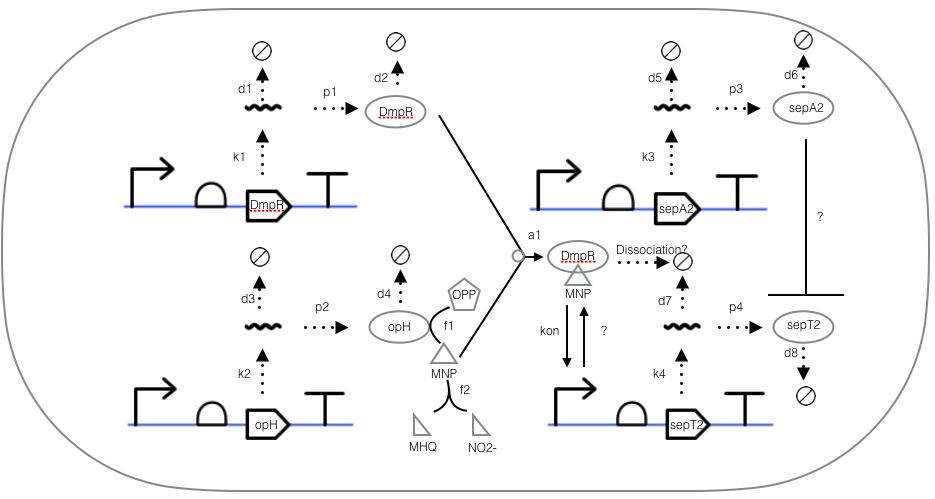


In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def activation(c, K=0.1, n=2):
    return c**n / (c**n + K**n)

def mechanism(y=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), t=[0, 0.5, 1]):
    mopH, opH, mDmpR, DmpR, msepT2, sepT2, msepA2, sepA2, OOP, MNP, DmpR_MNP = y
    
    # b_m, b_p : elimination by dilution (cell growth) and degradation of mRNA and protein
    # unit per time
    
    # lambda_p : transcription of protein from mRNA
    # unit per time
    
    # a_m : production rate of mRNA
    # concentration per time
    
    # f1 : pesticide decomposition rate
    # unit per concentration per time
    
    # a1 : association rate MNP+DmpR
    # unit per concentration per time

    # d1 : disssociation rate MNP+DmpR
    # unit per concentration per time

    # annihili : annihilation rate sepA2+sepT2
    # unit per concentration per time
    
    # for time scale use protein lifetime tau_p = 1/b_p
    #  i.e. rescale time with 1*b_p, such that b_p is set to 1
    
    b_p = 1
    b_sepA2 = 5
    
    b_m = 3.7
    a_m = 1
    a_m_DmpR = 0.1    # relatively weak promotor -> slower mRNA production rate
    a_m_sepA2 = 0.1   # relatively weak promotor -> slower mRNA production rate
    lambda_p = 67
    
    f1 = 0.1
    a1 = 5
    d1 = 0.1
    annihil = 10
    
    lambda_opH = lambda_DmpR = lambda_sepA2 = lambda_sepT2 = lambda_p

    dmopH = a_m - b_m * mopH
    dopH = lambda_opH * mopH - b_p*opH
    
    dmDmpR = a_m_DmpR - b_m * mDmpR
    dDmpR = lambda_DmpR * mDmpR - b_p*DmpR - a1 * MNP * DmpR + d1 * DmpR_MNP
    
    dOOP =  -f1 * OOP * opH
    dMNP = 2*f1 * OOP * opH - a1 * MNP * DmpR + d1 * DmpR_MNP
    dDmpR_MNP = a1 * MNP * DmpR - b_p*DmpR_MNP
    
    dmsepA2 = a_m_sepA2 - b_m * msepA2
    dsepA2 = lambda_sepA2 * msepA2 - b_sepA2*sepA2 - annihil*sepT2*sepA2
    
    dmsepT2 = activation(DmpR_MNP) - b_m * msepT2
    dsepT2 = lambda_sepT2 * msepT2 - b_p*sepT2 - annihil*sepT2*sepA2
    
    return [dmopH, dopH, dmDmpR, dDmpR, dmsepT2, dsepT2, dmsepA2, dsepA2, dOOP, dMNP, dDmpR_MNP]


In [3]:
mopH_slide     = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
opH_slide      = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
mDmpR_slide    = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
DmpR_slide     = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
msepT2_slide   = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
sepT2_slide    = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
msepA2_slide   = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
sepA2_slide    = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
OOP_slide      = widgets.FloatSlider(min=0, max=50, step=1,   continuous_update=False)
MNP_slide      = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
DmpR_MNP_slide = widgets.FloatSlider(min=0, max=10, step=0.5, continuous_update=False)
tt_slide       = widgets.FloatLogSlider(min=0, max=6, base=2,continuous_update=False)

@interact(mopH=mopH_slide, opH=opH_slide, mDmpR=mDmpR_slide, DmpR=DmpR_slide, msepT2=msepT2_slide, sepT2=sepT2_slide, msepA2=msepA2_slide, sepA2=sepA2_slide, OOP=OOP_slide, MNP=MNP_slide, DmpR_MNP=DmpR_MNP_slide, toxin_tolerance=tt_slide, continuous_update=False)
def simulate(mopH, opH=0, mDmpR=2, DmpR=0, msepT2=0.5, sepT2=5, msepA2=1, sepA2=0, OOP=0, MNP=0, DmpR_MNP=0, toxin_tolerance=6):
    initial = (mopH, opH, mDmpR, DmpR, msepT2, sepT2, msepA2, sepA2, OOP, MNP, DmpR_MNP)
    t = np.arange(0, 15.1, 0.1)
    mopH, opH, mDmpR, DmpR, msepT2, sepT2, msepA2, sepA2, OOP, MNP, DmpR_MNP = list(zip(*odeint(mechanism, initial, t)))
    labels = ["mopH", "opH", "mDmpR", "DmpR", "msepT2", "sepT2", "msepA2", "sepA2", "OOP", "MNP", "DmpR_MNP"]
    colors = ['green']*2 + ['blue']*2 + ['black']*2 + ['purple']*2 + ['red', 'orange', 'yellow']
    linestyles = [':','--']*4+['-']*3

    plt.figure(figsize=(9,5), dpi=100)
    for i, series in enumerate([mopH, opH, mDmpR, DmpR, msepT2, sepT2, msepA2, sepA2, OOP, MNP, DmpR_MNP]):
        plt.plot(t, series, label=labels[i], color = colors[i], linestyle=linestyles[i])
    death_times = np.where(np.array(sepT2) > toxin_tolerance)[0]
    if len(death_times) > 0:
        plt.axvline(t[death_times[0]], color='grey', linewidth=4)
        plt.text(t[death_times[0]], 200, "cell death")

    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.ylim([10e-3, 150])
    
    plt.axhline(toxin_tolerance, color='grey')
    plt.text(t[-1], toxin_tolerance, "toxin tolerance", verticalalignment='top',horizontalalignment='right')
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('concentration [arbitrary units]')
    plt.xlabel('time [rescaled by protein lifetime t_p]')
    plt.tight_layout()
    #plt.savefig('filename')

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='mopH', max=10.0, step=0.5),…

Explore how the circuit reacts for different initial conditions. 

You see the mRNA concentrations as dotted lines and the related protein concentrations in dashed lines of the same color. 
You see how the system evolves into a steady state where production and degradation are equally fast.

Introduce pesticide OOP and try to understand what happens.

What behavior did you expect? How can we tell if the kill switch works?

---
## Appendix

### Fall back image


In case your notebook viewer does not allow live execution, we include a screenshot of sliders and plot for reference


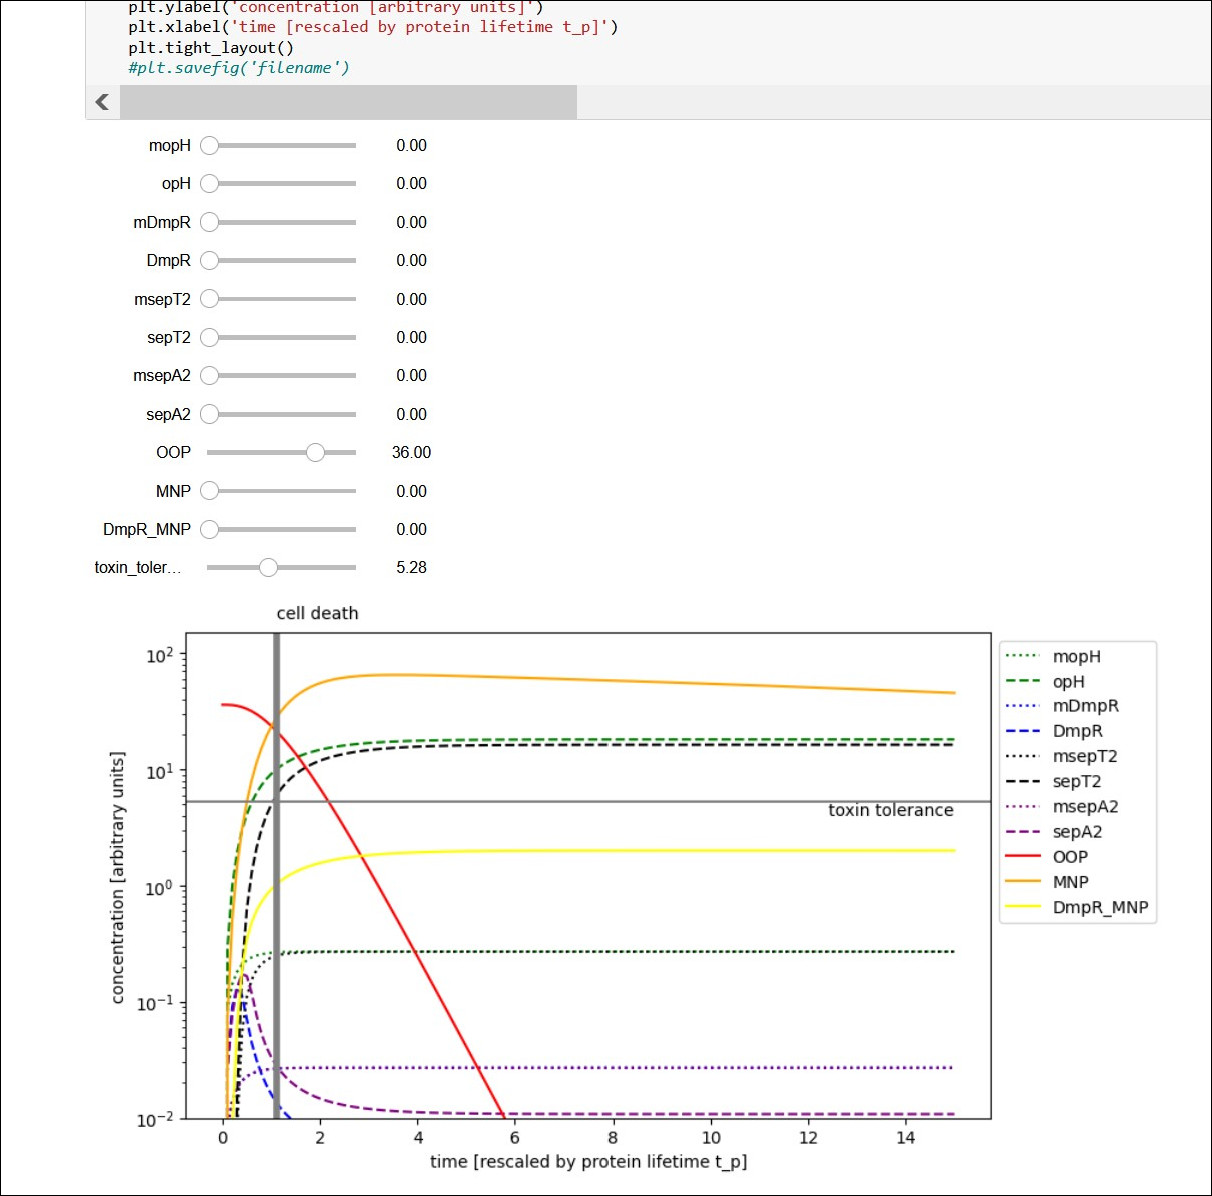




### Alternative circuit

By switching promotors of toxin and antitoxin, such that the toxin is always produced while expression of the antitoxin is conditinoal on the degradation product, we get this dynamic:


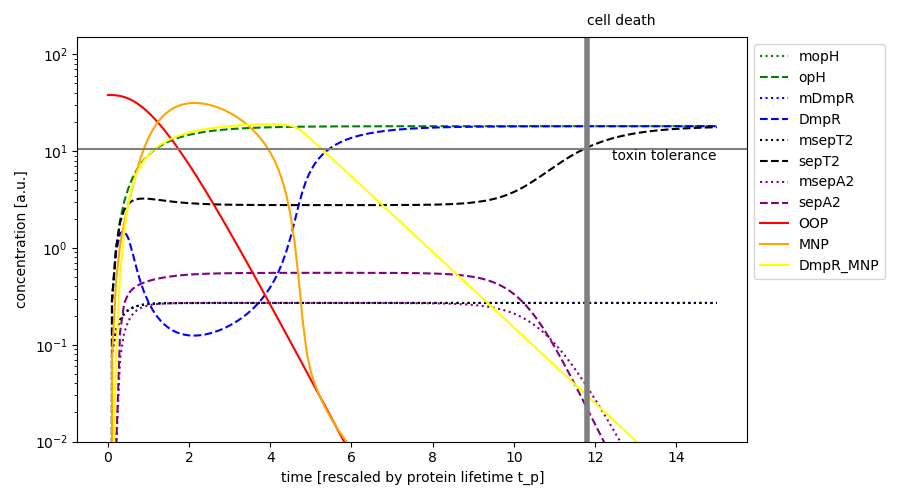

After pesticide and the degradation products are eliminated, the cell dies. This is desirable for containment, since the cyanobacteria can not spread outside of its target environment. However, laboratory experiments and storage need to happen in an environment with pesticide present at all times - raising it's own safety considerations.